In [42]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D
import mpl_toolkits.mplot3d.art3d as art3d
import seaborn as sns
import scipy.signal as sig
from scipy.signal import find_peaks

# Upload and inspect data

Long recordings

In [2]:
#inspecting the long recordings
long_1 = pd.read_csv('/Users/irenebernardi/Desktop/DS/miniproject/nsds2024-dsns2024-3d74831c793d/data/2023-11-09_09_06_39_Apple Watch.csv')
#visualize statistics
long_1.describe()

,accelerometerTimestamp_sinceReboot(s),accelerometerAccelerationX(G),accelerometerAccelerationY(G),accelerometerAccelerationZ(G),motionTimestamp_sinceReboot(s),motionYaw(rad),motionRoll(rad),motionPitch(rad),motionRotationRateX(rad/s),motionRotationRateY(rad/s),...,pedometerCurrentPace(s/m),pedometerCurrentCadence(steps/s),pedometerDistance(m),pedometerFloorAscended(N),pedometerFloorDescended(N),altimeterTimestamp_sinceReboot(s),altimeterReset(bool),altimeterRelativeAltitude(m),altimeterPressure(kPa),label
count,43159.000000,43159.000000,43159.000000,43159.000000,43159.000000,43159.000000,43159.000000,43159.000000,43159.000000,43159.000000,...,43159.000000,43159.000000,43159.000000,43159.000000,43159.0,4.315900e+04,43159.0,43159.000000,43159.000000,43159.0
mean,429850.305361,-0.981173,0.309916,-0.122881,429850.294751,-0.544595,-1.369558,-0.297430,-0.025537,-0.015286,...,0.683513,1.691973,4557.201726,2.076670,4.0,7.200037e+08,0.0,18.000197,100.944984,0.0
std,248.103995,0.562717,0.389063,0.305750,248.103195,2.545482,0.398201,0.247383,1.301268,1.117516,...,0.264236,0.663993,291.621777,0.391097,0.0,2.943289e+07,0.0,68.149810,4.126655,0.0
min,429420.584410,-9.166260,-4.385956,-1.925705,429420.568248,-3.141586,-3.139590,-1.558564,-12.593549,-6.193638,...,0.000000,0.000000,4028.711000,2.000000,4.0,0.000000e+00,0.0,-4.679993,0.000000,0.0
25%,429635.449332,-1.237076,0.189919,-0.250885,429635.443129,-2.870531,-1.574697,-0.483322,-0.541045,-0.712399,...,0.772800,1.789356,4297.020000,2.000000,4.0,7.212066e+08,0.0,-2.649994,101.103500,0.0
50%,429850.309369,-0.922104,0.269623,-0.133438,429850.303165,-2.066080,-1.424896,-0.255304,0.055939,-0.054339,...,0.794826,1.818410,4554.391000,2.000000,4.0,7.212068e+08,0.0,-1.330017,101.119300,0.0
75%,430065.162016,-0.732506,0.398216,0.000671,430065.145856,2.381404,-1.243518,-0.108334,0.558455,0.785688,...,0.806390,1.844723,4819.125000,2.000000,4.0,7.212070e+08,0.0,-0.020020,101.131200,0.0
max,430280.014687,3.018494,5.671677,4.324463,430279.998527,3.141566,3.139388,0.299595,14.181427,5.805107,...,1.286627,3.099673,5042.646000,5.000000,4.0,7.212073e+08,0.0,260.840000,101.154300,0.0


In [3]:
#finding timestamps for the pedometer
long_1['pedometerEndDate(txt)'] = pd.to_datetime(long_1['pedometerEndDate(txt)'])
long_1['pedometerStartDate(txt)'] = pd.to_datetime(long_1['pedometerStartDate(txt)'])
long_1['time_diff_seconds_pedometer'] = (long_1['pedometerEndDate(txt)'] - long_1['pedometerStartDate(txt)']).dt.total_seconds()
long_1['time_diff_seconds_pedometer']

0        93743.158
1        93743.158
2        93743.158
3        93743.158
4        93743.158
           ...    
43154    94604.699
43155    94604.699
43156    94604.699
43157    94604.699
43158    94604.699
Name: time_diff_seconds_pedometer, Length: 43159, dtype: float64

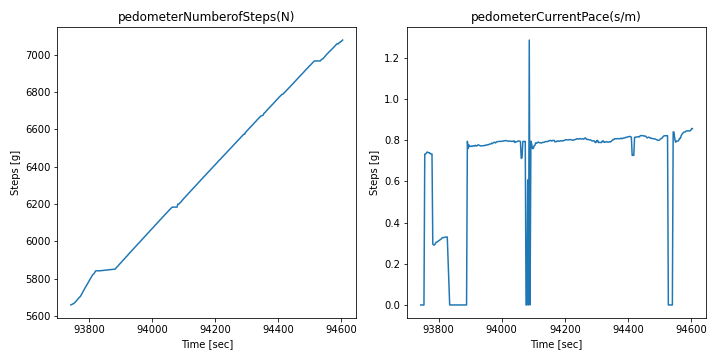

In [4]:
acccols3 = ['pedometerNumberofSteps(N)', 'pedometerCurrentPace(s/m)']

%matplotlib widget
fig, axes = plt.subplots (nrows=1, ncols=2, figsize=(10,5), sharex=True, squeeze=False)
axes = axes.flatten ()

xtime = long_1['time_diff_seconds_pedometer']
#xtime = xtime - xtime [0] we removed this for coherency with later calculations 

for axis, col in zip (axes, acccols3):
    yacc = long_1 [col]
    axis.plot (xtime, yacc, label=col)
    axis.set_title (col)
    axis.set_xlabel ('Time [sec]')
    axis.set_ylabel ('Steps [g]')

plt.tight_layout ()

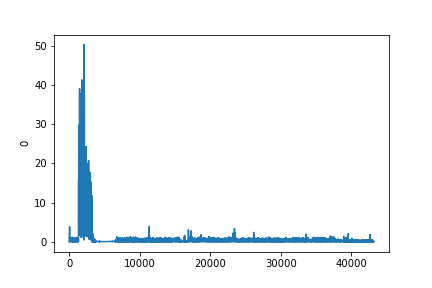

In [5]:
dot_products = []
md = long_1[['motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)']].copy()

# Loop over rows in the DataFrame
for i in range(len(md) - 1):
    # Get vectors for current and next row
    v1 = md.iloc[i].values
    v2 = md.iloc[i + 1].values

    # Calculate dot product and append to list
    dot_product = np.dot(v1, v2)
    dot_products.append(dot_product)

dot_products_series = pd.DataFrame(dot_products)

plt.figure()
# Plot the series
sns.lineplot(x=dot_products_series.index, y=dot_products_series[0], data=dot_products_series)
plt.show()

In [6]:
long_2 = pd.read_csv('/Users/irenebernardi/Desktop/DS/miniproject/nsds2024-dsns2024-3d74831c793d/data/2023-11-07_09_06_03_Apple Watch.csv')
#visualize statistics
long_2.describe()

,accelerometerTimestamp_sinceReboot(s),accelerometerAccelerationX(G),accelerometerAccelerationY(G),accelerometerAccelerationZ(G),motionTimestamp_sinceReboot(s),motionYaw(rad),motionRoll(rad),motionPitch(rad),motionRotationRateX(rad/s),motionRotationRateY(rad/s),...,pedometerCurrentPace(s/m),pedometerCurrentCadence(steps/s),pedometerDistance(m),pedometerFloorAscended(N),pedometerFloorDescended(N),altimeterTimestamp_sinceReboot(s),altimeterReset(bool),altimeterRelativeAltitude(m),altimeterPressure(kPa),label
count,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,38058.000000,...,38058.000000,38058.000000,38058.000000,38058.0,38058.000000,3.805800e+04,38058.0,38058.000000,38058.000000,38058.0
mean,405500.178736,-0.913243,0.332762,-0.097664,405500.163801,-0.361505,-1.384242,-0.331382,0.007776,-0.009532,...,0.620007,1.745685,1536.404206,1.0,1.867676,7.202193e+08,0.0,3.088619,101.349778,0.0
std,218.779724,0.600817,0.392247,0.337720,218.779724,1.198121,0.517940,0.299832,1.365022,1.095558,...,0.231172,0.637239,301.931394,0.0,0.338848,2.422296e+07,0.0,4.364934,3.409061,0.0
min,405121.250895,-9.749634,-3.764587,-1.987732,405121.235959,-3.141233,-3.137178,-1.567671,-13.193349,-6.202446,...,0.000000,0.000000,1029.374000,1.0,1.000000,0.000000e+00,0.0,-2.510010,0.000000,0.0
25%,405310.719097,-1.232498,0.173634,-0.223019,405310.704161,-0.990866,-1.573686,-0.459839,-0.606298,-0.676310,...,0.637680,1.871213,1263.498000,1.0,2.000000,7.210338e+08,0.0,-1.049988,101.417800,0.0
50%,405500.180770,-0.923088,0.295624,-0.095123,405500.165835,-0.446180,-1.446217,-0.274762,0.022809,-0.019085,...,0.726799,1.890239,1528.012000,1.0,2.000000,7.210339e+08,0.0,2.619995,101.470400,0.0
75%,405689.638989,-0.619270,0.427273,0.025967,405689.624055,-0.117342,-1.276313,-0.130712,0.632978,0.738176,...,0.743757,1.908147,1815.139000,1.0,2.000000,7.210341e+08,0.0,6.910004,101.513600,0.0
max,405879.100488,2.578156,4.629333,3.987122,405879.085553,3.141103,3.121368,0.428799,8.085984,6.224051,...,0.767011,2.989158,1972.857000,1.0,2.000000,7.210343e+08,0.0,22.540010,101.531200,0.0


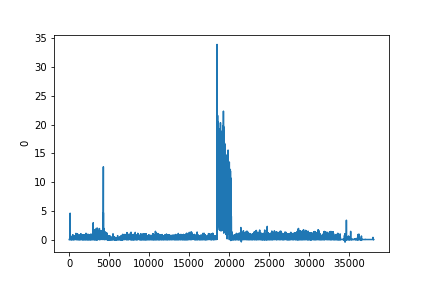

In [7]:
dot_products = []
md = long_2[['motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)']].copy()

# Loop over rows in the DataFrame
for i in range(len(md) - 1):
    # Get vectors for current and next row
    v1 = md.iloc[i].values
    v2 = md.iloc[i + 1].values

    # Calculate dot product and append to list
    dot_product = np.dot(v1, v2)
    dot_products.append(dot_product)

dot_products_series = pd.DataFrame(dot_products)

plt.figure()
# Plot the series
sns.lineplot(x=dot_products_series.index, y=dot_products_series[0], data=dot_products_series)
plt.show()

In [8]:
long_2['pedometerEndDate(txt)'] = pd.to_datetime(long_2['pedometerEndDate(txt)'])
long_2['pedometerStartDate(txt)'] = pd.to_datetime(long_2['pedometerStartDate(txt)'])
long_2['time_diff_seconds_pedometer'] = (long_2['pedometerEndDate(txt)'] - long_2['pedometerStartDate(txt)']).dt.total_seconds()
long_2['time_diff_seconds_pedometer']

0        4029.544
1        4029.544
2        4029.544
3        4029.544
4        4029.544
           ...   
38053    4768.734
38054    4768.734
38055    4768.734
38056    4768.734
38057    4768.734
Name: time_diff_seconds_pedometer, Length: 38058, dtype: float64

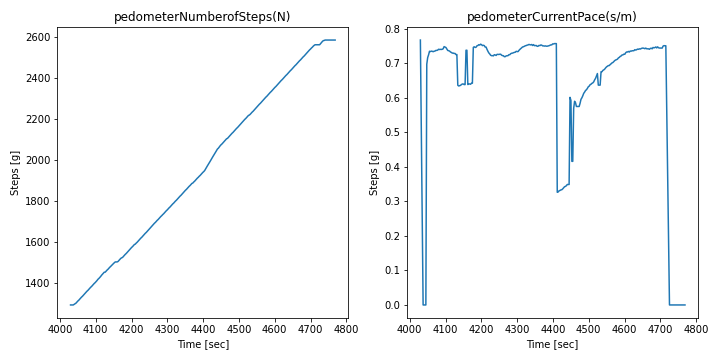

In [9]:
acccols3 = ['pedometerNumberofSteps(N)', 'pedometerCurrentPace(s/m)']

%matplotlib widget
fig, axes = plt.subplots (nrows=1, ncols=2, figsize=(10,5), sharex=True, squeeze=False)
axes = axes.flatten ()

xtime = long_2['time_diff_seconds_pedometer']
#xtime = xtime - xtime [0] we removed this for coherency with later calculations 

for axis, col in zip (axes, acccols3):
    yacc = long_2 [col]
    axis.plot (xtime, yacc, label=col)
    axis.set_title (col)
    axis.set_xlabel ('Time [sec]')
    axis.set_ylabel ('Steps [g]')

plt.tight_layout ()

Our actual data analysis will be on the short recordings for faster processing.

In [7]:
short_1 = pd.read_csv('/Users/irenebernardi/Desktop/DS/miniproject/nsds2024-dsns2024-3d74831c793d/data/2023-11-06_09_24_37_Apple Watch.csv')
short_1.describe()

,locationTimestamp_since1970(s),locationLatitude(WGS84),locationLongitude(WGS84),locationAltitude(m),locationSpeed(m/s),locationSpeedAccuracy(m/s),locationCourse(°),locationCourseAccuracy(°),locationVerticalAccuracy(m),locationHorizontalAccuracy(m),...,pedometerCurrentCadence(steps/s),pedometerDistance(m),pedometerFloorAscended(N),pedometerFloorDescended(N),altimeterTimestamp_sinceReboot(s),altimeterReset(bool),altimeterRelativeAltitude(m),altimeterPressure(kPa),batteryState(N),batteryLevel(R)
count,1790.0,1790.0,1790.0,1790.0,1790.0,1790.0,1790.0,1790.0,1790.0,1790.0,...,1790.000000,1790.000000,1790.0,1790.0,1.790000e+03,1790.0,1790.000000,1790.000000,1790.0,1.790000e+03
mean,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,...,2.141109,47.999567,0.0,0.0,7.209483e+08,0.0,-3.071070,101.747120,1.0,7.000000e-01
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.259696,27.656751,0.0,0.0,1.034083e+01,0.0,1.069624,0.014209,0.0,2.365436e-14
min,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,...,0.000000,7.403943,0.0,0.0,7.209483e+08,0.0,-4.899994,101.721200,1.0,7.000000e-01
25%,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,...,0.000000,20.807170,0.0,0.0,7.209483e+08,0.0,-3.970001,101.738800,1.0,7.000000e-01
50%,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,...,2.868151,50.196850,0.0,0.0,7.209483e+08,0.0,-3.269989,101.747200,1.0,7.000000e-01
75%,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,...,2.886676,73.209560,0.0,0.0,7.209483e+08,0.0,-2.390015,101.757300,1.0,7.000000e-01
max,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,...,2.924157,93.252620,0.0,0.0,7.209483e+08,0.0,-0.989990,101.769100,1.0,7.000000e-01


In [8]:
short_1.shape

(1790, 58)

In [9]:
#checking for null values 
short_1.isnull().sum()

loggingTime(txt)                             0
locationTimestamp_since1970(s)               0
locationLatitude(WGS84)                      0
locationLongitude(WGS84)                     0
locationAltitude(m)                          0
locationSpeed(m/s)                           0
locationSpeedAccuracy(m/s)                   0
locationCourse(°)                            0
locationCourseAccuracy(°)                    0
locationVerticalAccuracy(m)                  0
locationHorizontalAccuracy(m)                0
locationFloor(Z)                             0
accelerometerTimestamp_sinceReboot(s)        0
accelerometerAccelerationX(G)                0
accelerometerAccelerationY(G)                0
accelerometerAccelerationZ(G)                0
motionTimestamp_sinceReboot(s)               0
motionYaw(rad)                               0
motionRoll(rad)                              0
motionPitch(rad)                             0
motionRotationRateX(rad/s)                   0
motionRotatio

# Data Analysis

Making a separate dataframe with relevant sensors: accelerometerAcceleration and motionUserAcceleration

In [10]:
#first, finding timestamps for the accelerometerAcceleration 
short_1['accelerometerTimestamp_sinceReboot(s)'] = short_1['accelerometerTimestamp_sinceReboot(s)'] - short_1['accelerometerTimestamp_sinceReboot(s)'][0]
short_1['accelerometerTimestamp_sinceReboot(s)']

0        0.000000
1        0.019914
2        0.039829
3        0.059743
4        0.079658
          ...    
1785    35.547428
1786    35.567342
1787    35.587257
1788    35.607171
1789    35.627085
Name: accelerometerTimestamp_sinceReboot(s), Length: 1790, dtype: float64

In [11]:
short_1_copy= short_1.copy()
short_1_copy= short_1[['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)', 'motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)']]
short_1_copy

,accelerometerAccelerationX(G),accelerometerAccelerationY(G),accelerometerAccelerationZ(G),motionUserAccelerationX(G),motionUserAccelerationY(G),motionUserAccelerationZ(G)
0,-0.002411,0.208420,-1.136719,0.080129,0.028666,-0.172331
1,-0.103012,0.114624,-1.129150,0.090324,-0.016977,-0.166030
2,-0.106857,0.172791,-1.137863,0.064962,-0.066362,-0.168792
3,-0.176605,0.260345,-1.103073,0.020608,0.031249,-0.156098
4,-0.250320,0.290787,-1.013153,-0.050174,0.096728,-0.097673
...,...,...,...,...,...,...
1785,-0.303223,-0.016769,-1.551071,-0.016265,0.245777,-0.580462
1786,-0.363525,-0.109253,-1.439026,-0.165975,0.044570,-0.541288
1787,-0.228836,-0.224930,-1.214386,-0.127869,-0.114395,-0.353843
1788,-0.186478,-0.194382,-0.995377,0.065926,-0.180930,-0.135169


Inspecting correlation values between accelerometerAcceleration sensor and motionUserAcceleration sensor.

In [12]:
corr = short_1_copy.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, vmax = 1, vmin = -1, center = 0, cmap= 'coolwarm')

<AxesSubplot:>

In [13]:
#pick accelerometer subsequent vectors in time and do dot product 
accelerometer_data = short_1_copy[['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)', 'accelerometerAccelerationZ(G)']].copy()

motion_data = short_1_copy[['motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)']].copy()


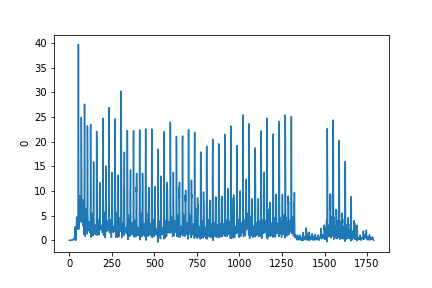

In [28]:
dot_products = []

# Loop over rows in the DataFrame
for i in range(len(motion_data) - 1):
    # Get vectors for current and next row
    v1 = motion_data.iloc[i].values
    v2 = motion_data.iloc[i + 1].values

    # Calculate dot product and append to list
    dot_product = np.dot(v1, v2)
    dot_products.append(dot_product)

dot_products_series = pd.DataFrame(dot_products)


# Plot the series
plt.figure()
sns.lineplot(x=dot_products_series.index, y=dot_products_series[0], data=dot_products_series)
plt.show()


Inspecting pedometer values in order to compare step count with differences in frequencies in the accelerometerAcceleration sensor and motionUserAcceleration sensor.

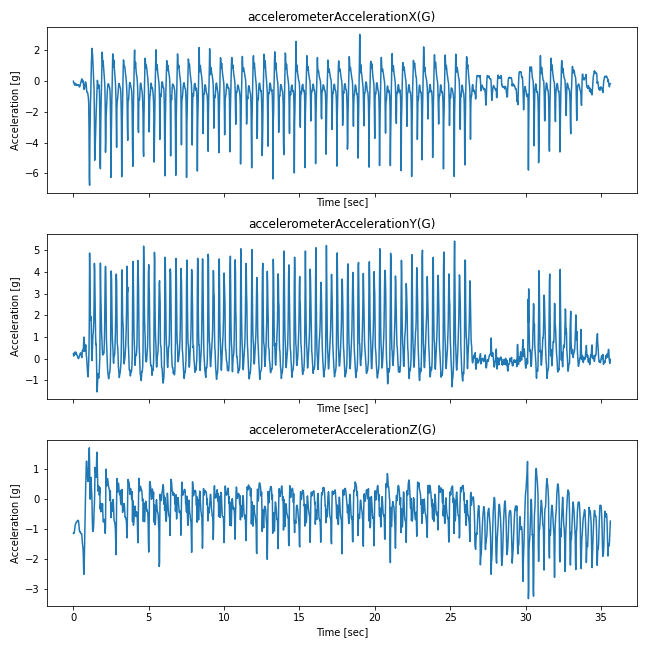

In [29]:
%matplotlib widget

#plotting pieces of the data based on accelerometer for later comparision with pedometer values

acccols = ['accelerometerAccelerationX(G)', 'accelerometerAccelerationY(G)',
           'accelerometerAccelerationZ(G)']

fig, axes = plt.subplots (nrows=3, ncols=1, figsize=(9,9), sharex=True, squeeze=False)
axes = axes.flatten ()

xtime = short_1['accelerometerTimestamp_sinceReboot(s)']
xtime = xtime - xtime [0]

for axis, col in zip (axes, acccols):
    yacc = short_1 [col]
    axis.plot (xtime, yacc, label=col)
    axis.set_title (col)
    axis.set_xlabel ('Time [sec]')
    axis.set_ylabel ('Acceleration [g]')

plt.tight_layout ()

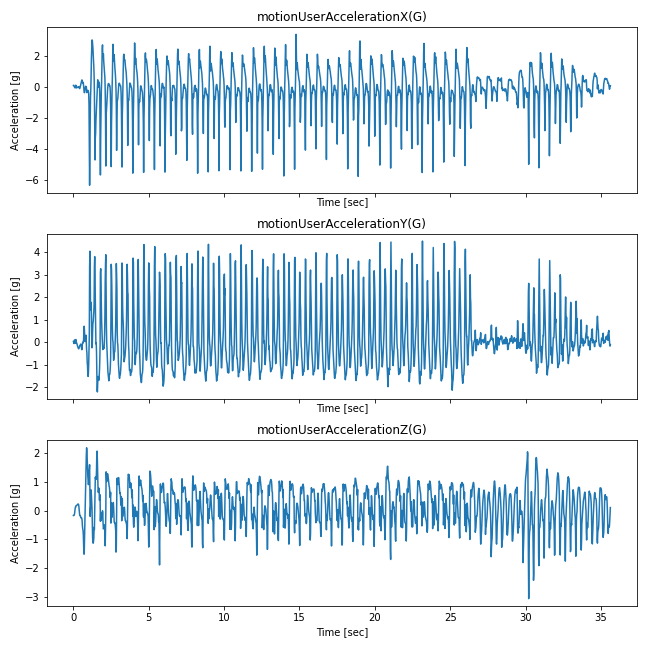

In [30]:
#plotting pieces of the data based on motion user for later comparison with pedometer values
%matplotlib widget


acccols2 = ['motionUserAccelerationX(G)', 'motionUserAccelerationY(G)',
           'motionUserAccelerationZ(G)']

fig, axes = plt.subplots (nrows=3, ncols=1, figsize=(9,9), sharex=True, squeeze=False)
axes = axes.flatten ()

xtime = short_1['motionTimestamp_sinceReboot(s)']
xtime = xtime - xtime [0]

for axis, col in zip (axes, acccols2):
    yacc = short_1[col]
    axis.plot (xtime, yacc, label=col)
    axis.set_title (col)
    axis.set_xlabel ('Time [sec]')
    axis.set_ylabel ('Acceleration [g]')

plt.tight_layout ()

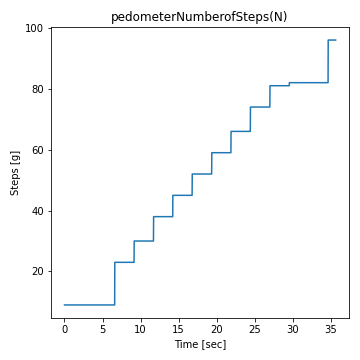

In [31]:
#inspecting data based on pedometer
acccols3 = ['pedometerNumberofSteps(N)']

%matplotlib widget
fig, axes = plt.subplots (nrows=1, ncols=1, figsize=(5,5), sharex=True, squeeze=False)
axes = axes.flatten ()

xtime = short_1['motionTimestamp_sinceReboot(s)']
xtime = xtime - xtime [0]

for axis, col in zip (axes, acccols3):
    yacc = short_1 [col]
    axis.plot (xtime, yacc, label=col)
    axis.set_title (col)
    axis.set_xlabel ('Time [sec]')
    axis.set_ylabel ('Steps [g]')

plt.tight_layout ()

In [32]:
#finding timestamps for the pedometer
short_1['pedometerEndDate(txt)'] = pd.to_datetime(short_1['pedometerEndDate(txt)'])
short_1['pedometerStartDate(txt)'] = pd.to_datetime(short_1['pedometerStartDate(txt)'])
short_1['time_diff_seconds_pedometer'] = (short_1['pedometerEndDate(txt)'] - short_1['pedometerStartDate(txt)']).dt.total_seconds()
short_1['time_diff_seconds_pedometer']

0        21.328
1        21.328
2        21.328
3        21.328
4        21.328
         ...   
1785    128.389
1786    128.389
1787    128.389
1788    128.389
1789    128.389
Name: time_diff_seconds_pedometer, Length: 1790, dtype: float64

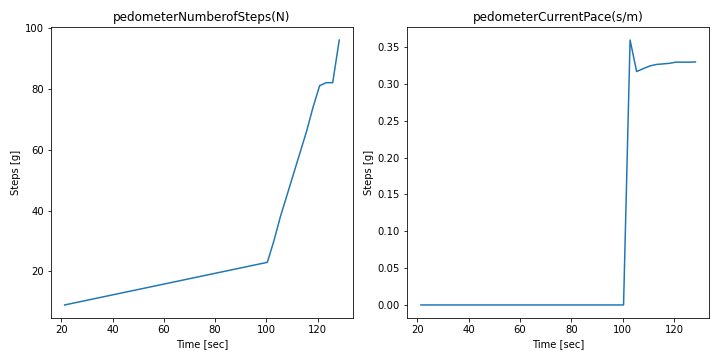

In [33]:
#confirming our findings by comparing steps and pace of pedometer
acccols3 = ['pedometerNumberofSteps(N)', 'pedometerCurrentPace(s/m)']

%matplotlib widget
fig, axes = plt.subplots (nrows=1, ncols=2, figsize=(10,5), sharex=True, squeeze=False)
axes = axes.flatten ()

xtime =short_1['time_diff_seconds_pedometer']
#xtime = xtime - xtime [0] we removed this for coherency with later calculations 

for axis, col in zip (axes, acccols3):
    yacc = short_1 [col]
    axis.plot (xtime, yacc, label=col)
    axis.set_title (col)
    axis.set_xlabel ('Time [sec]')
    axis.set_ylabel ('Steps [g]')

plt.tight_layout ()

Exploring timescales


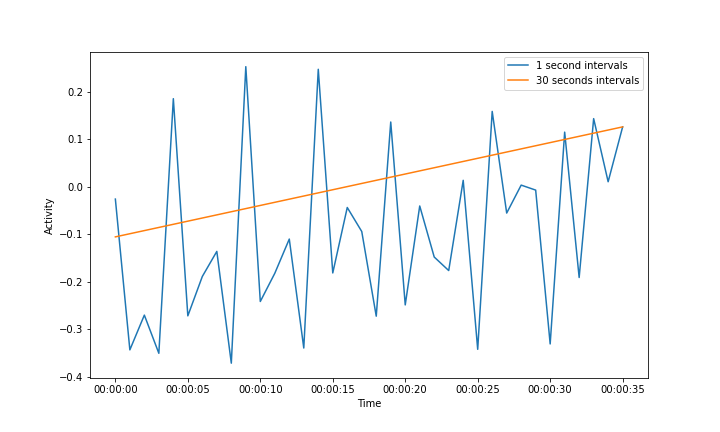

In [20]:
# Convert the time column to a datetime index
motion_data.index = pd.to_datetime(short_1['accelerometerTimestamp_sinceReboot(s)'], unit='s')
signal = motion_data['motionUserAccelerationX(G)']

# Resampling the data at different time scales
resampled_1s = signal.resample('1S').mean()  # 1 second intervals
resampled_30s = signal.resample('35S').mean()  # 30 seconds intervals

plt.figure(figsize=(10, 6))
plt.plot(resampled_1s, label='1 second intervals')
plt.plot(resampled_30s, label='30 seconds intervals')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()
plt.show()

In [34]:
#find sampling frequency
xtime = short_1['motionTimestamp_sinceReboot(s)']
xtime = xtime - xtime [0]
#sampling frequency: difference between consecutive timestamps 
sampling_freq = 1 /  np.mean (np.diff (xtime)) #the reciprocal of difference is SF
print (f'Sampling frequency: {sampling_freq:.2f} Hz')

Sampling frequency: 50.21 Hz


In [21]:
short_1[['time_diff_seconds_pedometer', 'pedometerNumberofSteps(N)']]

short_1.loc[short_1['time_diff_seconds_pedometer'] >= 0, ['time_diff_seconds_pedometer', 'pedometerNumberofSteps(N)']].drop_duplicates()

,time_diff_seconds_pedometer,pedometerNumberofSteps(N)
0,21.328,9
332,100.349,23
460,102.898,30
588,105.447,38
715,107.996,45
843,110.545,52
972,113.094,59
1099,115.643,66
1227,118.192,74
1356,120.741,81


In [22]:
#finding overall frequency 
xtime = short_1['time_diff_seconds_pedometer']

total_steps = short_1['pedometerNumberofSteps(N)'].max()
total_time = xtime.max()  # assuming xtime is in seconds
frequency_total = total_steps / total_time  # steps per second

frequency_total 

0.7477276090630817

In [23]:
#finding walking frequency
xtime = short_1['time_diff_seconds_pedometer']

walk_steps = 23 
walk_time = 100.349
frequency_walk = walk_steps / walk_time  # steps per second

frequency_walk  

0.22920009168003666

In [24]:
#finding running frequency
xtime = short_1['time_diff_seconds_pedometer']

run_steps = total_steps - walk_steps 
run_time = total_time - walk_time
frequency_run = run_steps / run_time  # steps per second

frequency_run  

2.60342368045649

# Fourier Transforms of signal components.

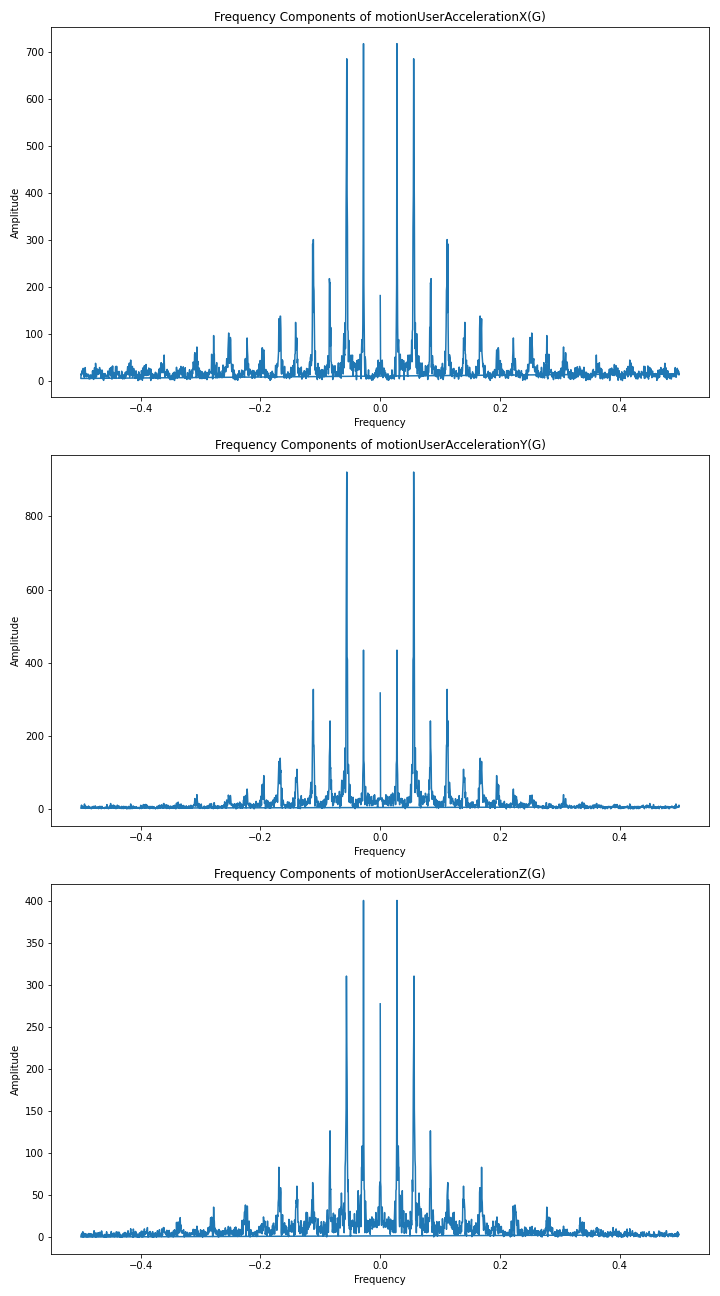

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

for ax, column in zip(axs, ['motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)']):
    # Get the signal data
    signal = motion_data[column]
    # Use fft to get the frequency components
    fft_result = np.fft.fft(signal)

    # Calculate the magnitudes
    magnitudes = np.abs(fft_result)

    # Calculate the frequencies
    frequencies = np.fft.fftfreq(len(signal))

    # Plot the magnitudes against the frequencies
    ax.plot(frequencies, magnitudes)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Frequency Components of {column}')

plt.tight_layout()
plt.show()

Plotting Signal Frequency using specgram. 

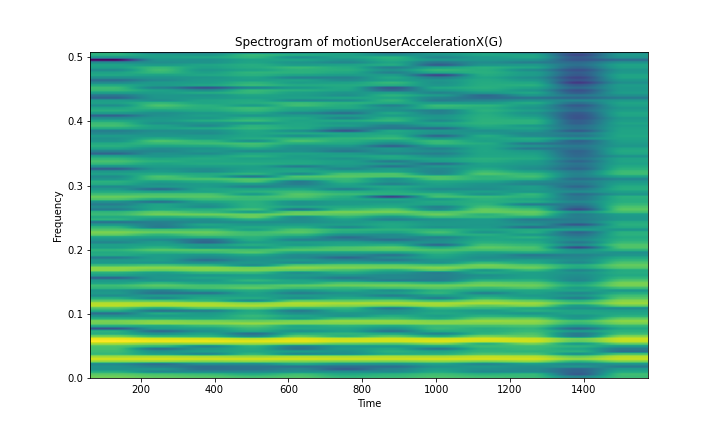

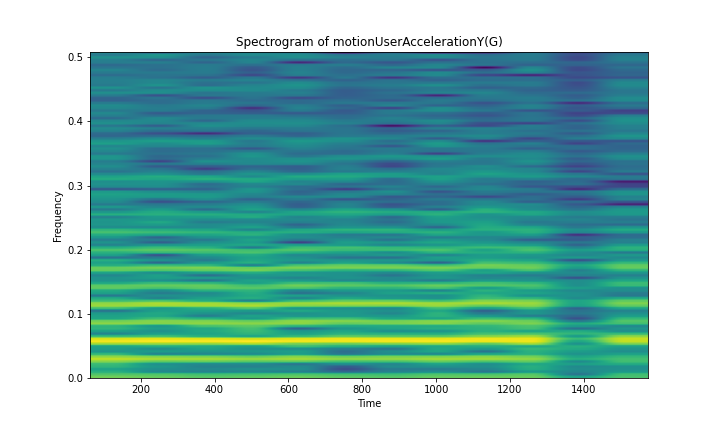

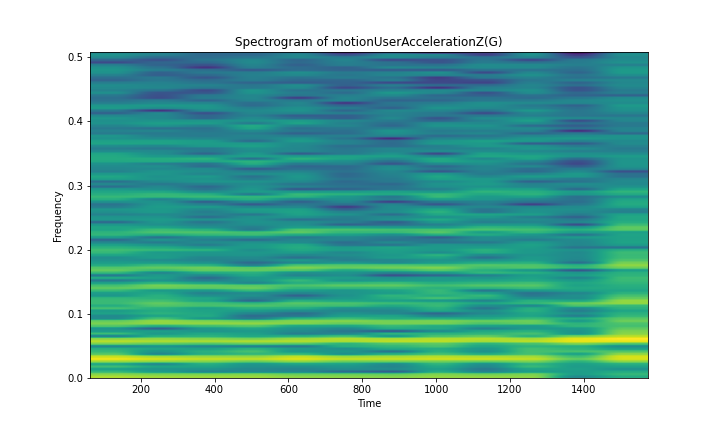

In [26]:
import matplotlib.pyplot as plt

# Assuming 'motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)' are your motion data columns
for column in ['motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)']:
    plt.figure(figsize=(10, 6))
    plt.specgram(motion_data[column], NFFT=256, Fs=1.017, noverlap=128)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Spectrogram of {column}')
    plt.show()

Trying to find differences in left vs right pattern of moving

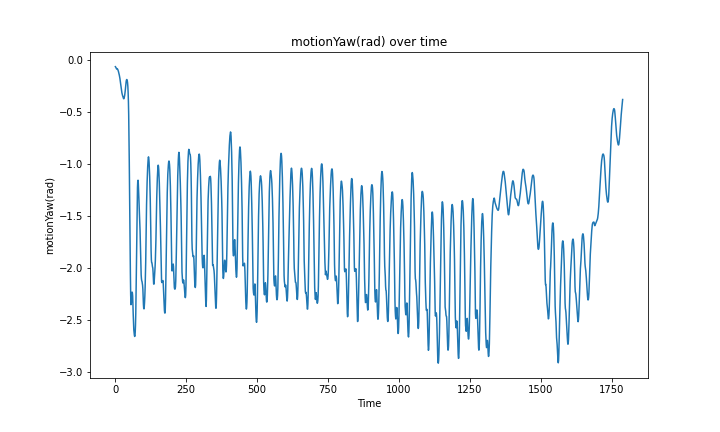

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(short_1['motionYaw(rad)'])
plt.title('motionYaw(rad) over time')
plt.xlabel('Time')
plt.ylabel('motionYaw(rad)')
plt.show()

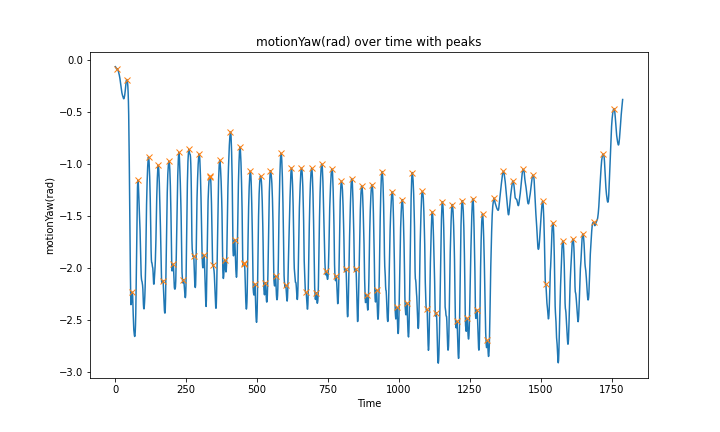

In [41]:
signal = short_1['motionYaw(rad)']

# Find peaks
peaks, _ = find_peaks(signal)
plt.figure(figsize=(10, 6))
plt.plot(signal)
plt.plot(peaks, signal[peaks], "x")
plt.title('motionYaw(rad) over time with peaks')
plt.xlabel('Time')
plt.ylabel('motionYaw(rad)')
plt.show()